In [2]:
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import torch         
import torch.nn as nn    
import torch.nn.functional as F   
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from PIL import Image 
import imageio 
from early_stopping import EarlyStopping
import os, gc
import random 
from matplotlib.ticker import MultipleLocator
from matplotlib.backends.backend_pdf import PdfPages

def print_result_DNN(n_vector,m_vector,path):
    n_vector = np.sort(n_vector)
    m_vector = np.sort(m_vector)
    nnressum = np.zeros((len(n_vector), len(m_vector)))
    for i in range(len(n_vector)): 
        for j in range(len(m_vector)): 
            n_train = n_vector[i]
            m_train = m_vector[j]

            resnmdd = np.load(path+str(n_train)+"m"+str(m_train)+".npy",allow_pickle=True) 

            col_indexes = np.arange(0, resnmdd.shape[1], 3) 
            idx = np.argmin(resnmdd[:,col_indexes],axis=1)
            resnmdd[np.arange(resnmdd.shape[0]),np.argmin(resnmdd[:,col_indexes],axis=1)]
            kk1 = np.array([(resnmdd[i, 3*idx[i]], resnmdd[i, 3*idx[i]+1], resnmdd[i, 3*idx[i]+2]) for i in range(resnmdd.shape[0])])  
            kk1 = kk1.mean(axis=0) 
            nnressum[i][j] = kk1[1]
    return nnressum

def print_result_slr(n_vector,m_vector,path):
    n_vector = np.sort(n_vector)
    m_vector = np.sort(m_vector)
    nnressum = np.zeros((len(n_vector), len(m_vector)))
    hypopt = []
    for i in range(len(n_vector)): 
        for j in range(len(m_vector)): 
            n_train = n_vector[i]
            m_train = m_vector[j]

            resnmdd = np.load(path+str(n_train)+"m"+str(m_train)+".npy",allow_pickle=True) 
            rc = resnmdd.shape[0]
            hyp = []
            testerror = []
            
            for k in range(rc):
                testerror.append(resnmdd[k][1])
                indopth = resnmdd[k][0][:,0].argmin()
                lambdaopt = np.array(resnmdd[k][0])[indopth,1]
                hyp.append(lambdaopt)
            hypopt.append(hyp)
            nnressum[i][j] = np.mean(testerror)
    hypopt = np.array(hypopt).reshape(len(n_vector),len(m_vector),rc)
    return nnressum

## Figure of Case1-6

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


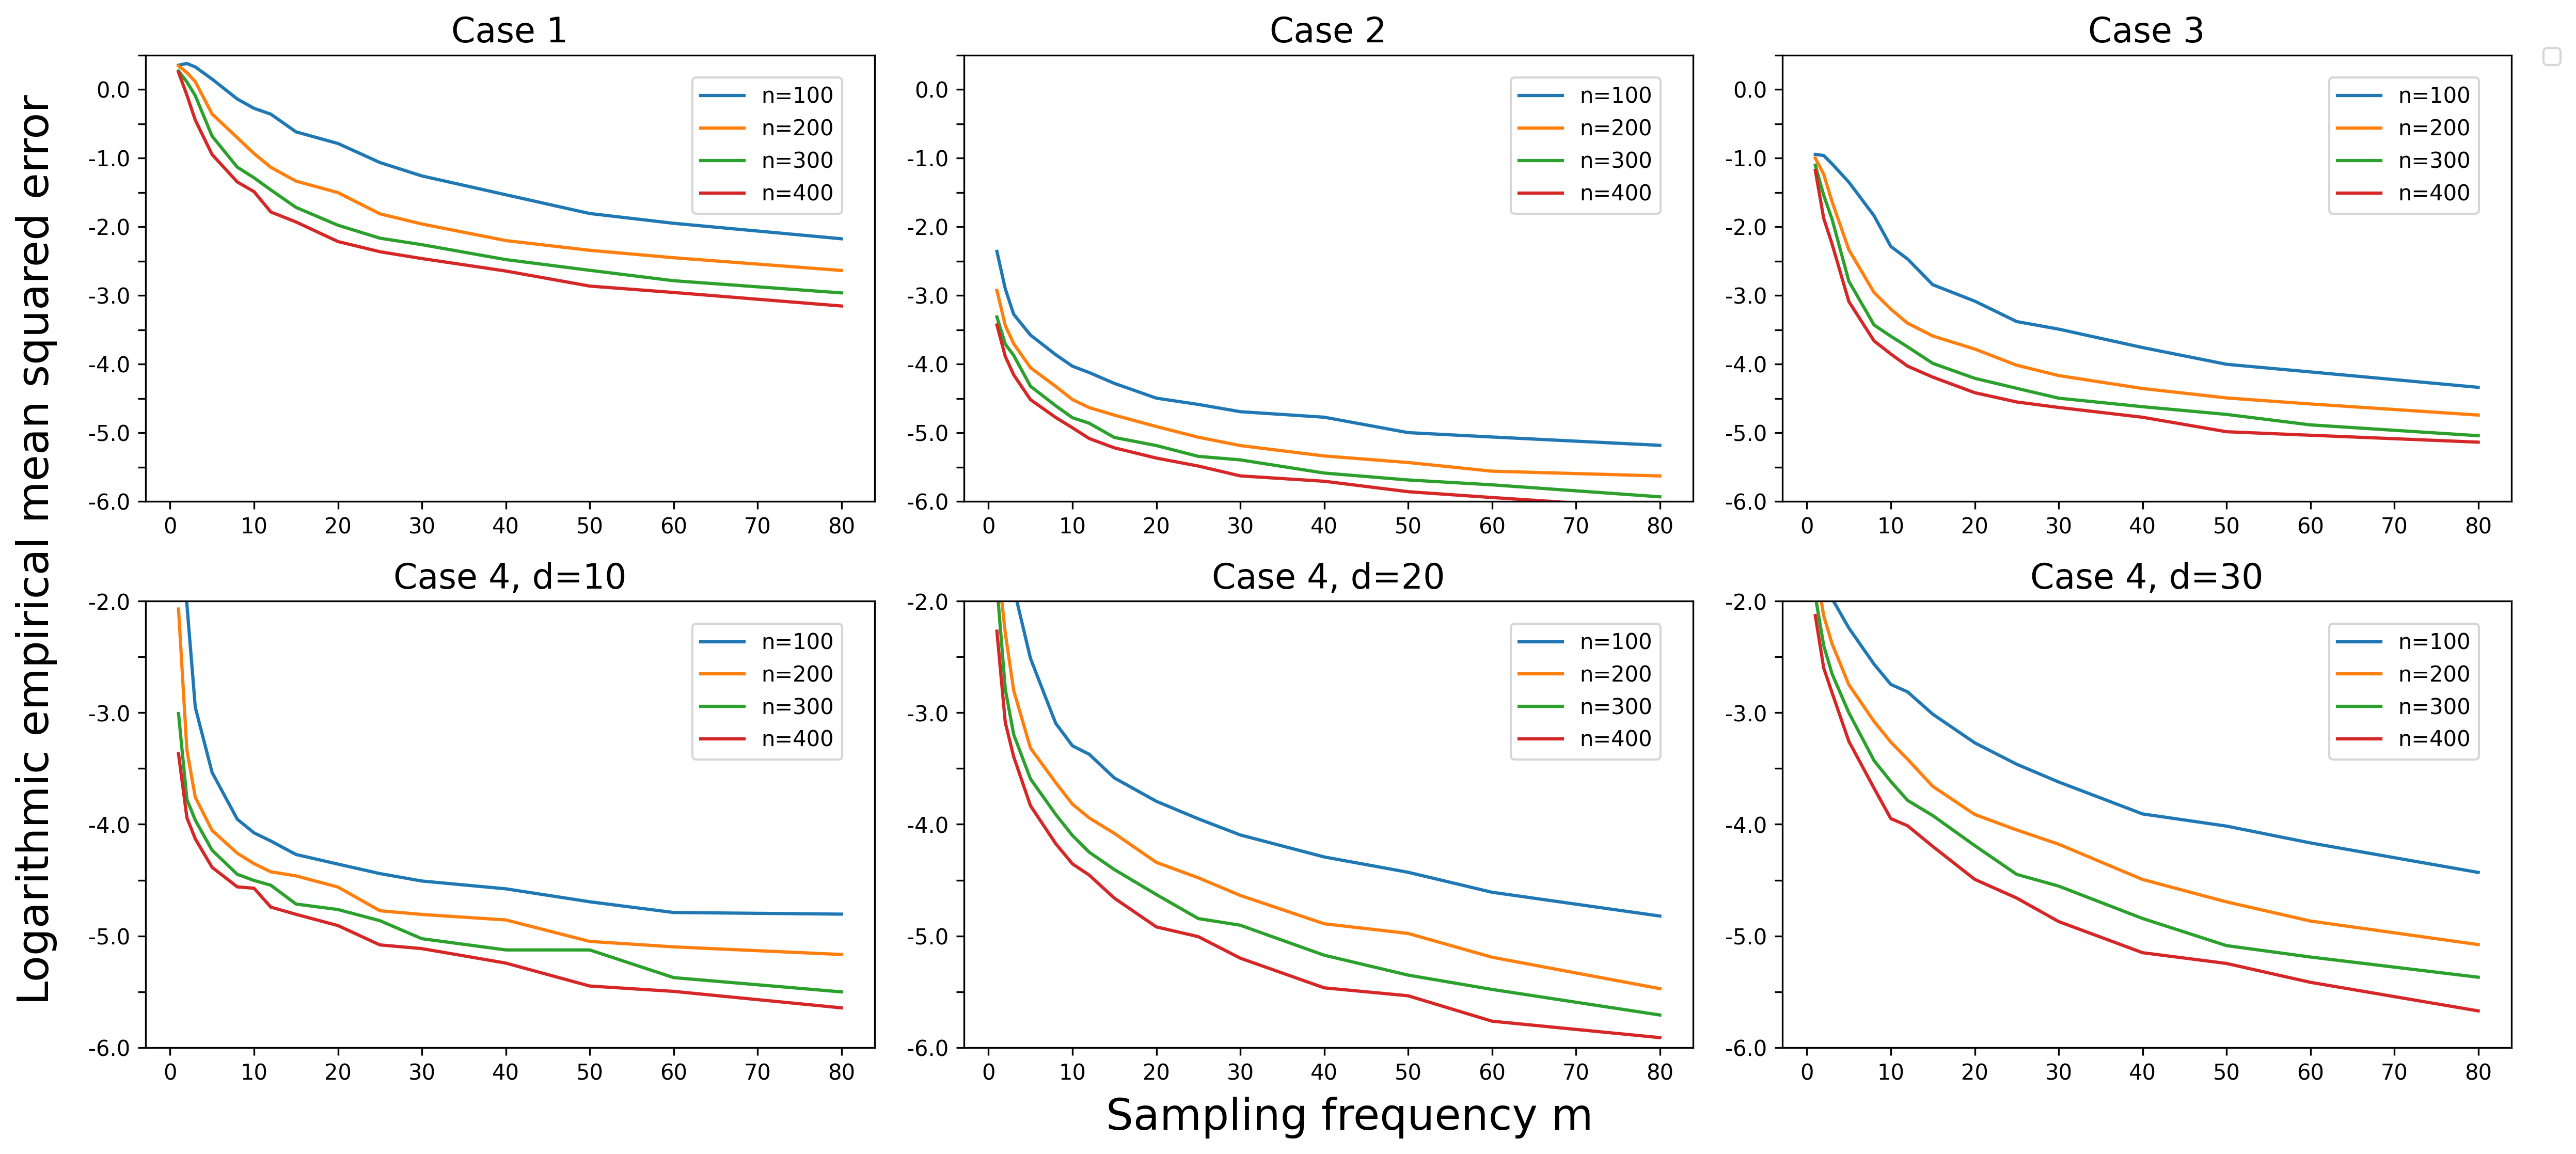

In [3]:
n_vector = [100,200,300,400] 
m_vector = [1,2,3,5,8,10,12,15,20,25,30,40,50,60,80] 

def subplotv(ax,n_vector,m_vector,path,title1,ylim = None,yticks=None):
    nnressum = np.zeros((len(n_vector), len(m_vector)))
    for i in range(len(n_vector)): 
        for j in range(len(m_vector)): 
            n_train = n_vector[i]
            m_train = m_vector[j]

            resnmdd = np.load(path+str(n_train)+"m"+str(m_train)+".npy",allow_pickle=True) 

            col_indexes = np.arange(0, resnmdd.shape[1], 3) 
            idx = np.argmin(resnmdd[:,col_indexes],axis=1)
            resnmdd[np.arange(resnmdd.shape[0]),np.argmin(resnmdd[:,col_indexes],axis=1)]
            kk1 = np.array([(resnmdd[i, 3*idx[i]], resnmdd[i, 3*idx[i]+1], resnmdd[i, 3*idx[i]+2]) for i in range(resnmdd.shape[0])])  
            kk1 = kk1.mean(axis=0) 
            nnressum[i][j] = kk1[1] 
    # 生成数据
    x = np.sort(m_vector)
    for i in range(len(n_vector)):
        ax.plot(x, np.log(nnressum[i,:]), label='n='+str(n_vector[i])) 

    if ((ylim is None) is False):
        ax.set_ylim(ylim)
        if ((yticks is None) is False):
            ax.set_yticks(yticks,yticks)

    y_major_locator=MultipleLocator(0.5)#以每3显示
    ax.legend(loc=2, bbox_to_anchor=(0.75,0.95), borderaxespad = 0.)
    ax.yaxis.set_major_locator(y_major_locator)
    ax.set_title(title1,size = 16)

fig, ((ax1, ax2, ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, dpi=300,figsize=(16,7.2))
fig.text(s='Logarithmic empirical mean squared error',rotation=90,x = -0.02, y = 0.1,fontsize = 20,) 
fig.text(s='Sampling frequency m',x = 0.42, y = -0.02, fontsize = 20) 
fig.legend(loc=2, bbox_to_anchor=(1,0.95), borderaxespad = 0.)
path = "./Case1/res/res" 
subplotv(ax1,n_vector,m_vector,path,title1='Case 1',ylim = (-6,0.5), yticks=np.linspace(-6,0,7))#
path = "./Case2/res/res" 
subplotv(ax2,n_vector,m_vector,path,title1='Case 2',ylim = (-6,0.5), yticks=np.linspace(-6,0,7))
path = "./Case3/res/res" 
subplotv(ax3,n_vector,m_vector,path,title1='Case 3',ylim = (-6,0.5), yticks=np.linspace(-6,0,7))
path = "./Case4/10d/res/res" 
subplotv(ax4,n_vector,m_vector,path,title1='Case 4, d=10',ylim = (-6,-2), yticks=np.linspace(-6,-2,5))
path = "./Case4/20d/res/res" 
subplotv(ax5,n_vector,m_vector,path,title1='Case 4, d=20',ylim = (-6,-2), yticks=np.linspace(-6,-2,5))
path = "./Case4/30d/res/res" 
subplotv(ax6,n_vector,m_vector,path,title1='Case 4, d=30',ylim = (-6,-2), yticks=np.linspace(-6,-2,5))
plt.tight_layout()

## Case 1

In [4]:
n_vector = [100,300] 
m_vector = [10,30] 
path = "./Case1/res/res" 
res1 = print_result_DNN(n_vector,m_vector,path) 

path = "./Case1/res/regsp" 
res2 = print_result_slr(n_vector,m_vector,path) 

path = "./Case1/res/rkhsreg" 
res3 = print_result_slr(n_vector,m_vector,path) 

path = "./Case1/res/locallinear" 
res4 = print_result_slr(n_vector,m_vector,path) 

res1,res2,res3,res4

print('&' ,'%.4f'% res1[0,0], '&' ,'%.4f'% res1[0,1], '&&' ,'%.4f'% res1[1,0], '&' ,'%.4f'% res1[1,1])
print('&' ,'%.4f'% res2[0,0], '&' ,'%.4f'% res2[0,1], '&&' ,'%.4f'% res2[1,0], '&' ,'%.4f'% res2[1,1])
print('&' ,'%.4f'% res3[0,0], '&' ,'%.4f'% res3[0,1], '&&' ,'%.4f'% res3[1,0], '&' ,'%.4f'% res3[1,1])
print('&' ,'%.4f'% res4[0,0], '&' ,'%.4f'% res4[0,1], '&&' ,'%.4f'% res4[1,0], '&' ,'%.4f'% res4[1,1])

& 0.7598 & 0.2839 && 0.2762 & 0.1043
& 1.5913 & 0.8543 && 0.7995 & 0.3080
& 0.8289 & 0.4630 && 0.4652 & 0.2205
& 1.3112 & 0.9221 && 0.8854 & 0.6147


## Case2

In [3]:
n_vector = [100,300] 
m_vector = [10,30] 
path = "./Case2/res/res" 
res1 = print_result_DNN(n_vector,m_vector,path) 

path = "./Case2/res/regsp" 
res2 = print_result_slr(n_vector,m_vector,path) 

path = "./Case2/res/rkhsreg" 
res3 = print_result_slr(n_vector,m_vector,path) 

path = "./Case2/res/locallinear" 
res4 = print_result_slr(n_vector,m_vector,path) 

res1,res2,res3,res4

print('&' ,'%.4f'% res1[0,0], '&' ,'%.4f'% res1[0,1], '&&' ,'%.4f'% res1[1,0], '&' ,'%.4f'% res1[1,1])
print('&' ,'%.4f'% res2[0,0], '&' ,'%.4f'% res2[0,1], '&&' ,'%.4f'% res2[1,0], '&' ,'%.4f'% res2[1,1])
print('&' ,'%.4f'% res3[0,0], '&' ,'%.4f'% res3[0,1], '&&' ,'%.4f'% res3[1,0], '&' ,'%.4f'% res3[1,1])
print('&' ,'%.4f'% res4[0,0], '&' ,'%.4f'% res4[0,1], '&&' ,'%.4f'% res4[1,0], '&' ,'%.4f'% res4[1,1])

& 0.0178 & 0.0092 && 0.0084 & 0.0045
& 0.2105 & 0.0570 && 0.0570 & 0.0333
& 0.0264 & 0.0130 && 0.0129 & 0.0069
& 0.6633 & 0.4535 && 0.5883 & 0.2353


## Case3

In [4]:
n_vector = [100,300] 
m_vector = [10,30] 
path = "./Case3/res/res" 
res1 = print_result_DNN(n_vector,m_vector,path) 

path = "./Case3/res/regsp" 
res2 = print_result_slr(n_vector,m_vector,path) 

path = "./Case3/res/rkhsreg" 
res3 = print_result_slr(n_vector,m_vector,path) 

path = "./Case3/res/locallinear" 
res4 = print_result_slr(n_vector,m_vector,path) 

print('&' ,'%.4f'% res1[0,0], '&' ,'%.4f'% res1[0,1], '&&' ,'%.4f'% res1[1,0], '&' ,'%.4f'% res1[1,1])
print('&' ,'%.4f'% res2[0,0], '&' ,'%.4f'% res2[0,1], '&&' ,'%.4f'% res2[1,0], '&' ,'%.4f'% res2[1,1])
print('&' ,'%.4f'% res3[0,0], '&' ,'%.4f'% res3[0,1], '&&' ,'%.4f'% res3[1,0], '&' ,'%.4f'% res3[1,1])
print('&' ,'%.4f'% res4[0,0], '&' ,'%.4f'% res4[0,1], '&&' ,'%.4f'% res4[1,0], '&' ,'%.4f'% res4[1,1])

& 0.1016 & 0.0305 && 0.0275 & 0.0112
& 0.2170 & 0.0518 && 0.0464 & 0.0100
& 0.1090 & 0.0401 && 0.0390 & 0.0149
& 0.2371 & 0.1395 && 0.1472 & 0.1260


## Case4: d=10

In [6]:
n_vector = [100,300] 
m_vector = [10,30] 
path = "./Case4/10d/res/res" 
res1 = print_result_DNN(n_vector,m_vector,path) 

path = "./Case4/10d/res/rkhsreg" 
res3 = print_result_slr(n_vector,m_vector,path) 

path = "./Case4/10d/res/locallinear" 
res4 = print_result_slr(n_vector,m_vector,path) 

res1,res3,res4


print('&' ,'%.4f'% res1[0,0], '&' ,'%.4f'% res1[0,1], '&&' ,'%.4f'% res1[1,0], '&' ,'%.4f'% res1[1,1])
print('&' ,'%.4f'% res3[0,0], '&' ,'%.4f'% res3[0,1], '&&' ,'%.4f'% res3[1,0], '&' ,'%.4f'% res3[1,1])
print('&' ,'%.4f'% res4[0,0], '&' ,'%.4f'% res4[0,1], '&&' ,'%.4f'% res4[1,0], '&' ,'%.4f'% res4[1,1])

& 0.0170 & 0.0110 && 0.0111 & 0.0066
& 0.1996 & 0.1100 && 0.1104 & 0.0573
& 0.5246 & 0.3767 && 0.3988 & 0.2447


## Case4:d=20

In [7]:
n_vector = [100,300] 
m_vector = [10,30] 
path = "./Case4/20d/res/res" 
res1 = print_result_DNN(n_vector,m_vector,path) 

path = "./Case4/20d/res/rkhsreg" 
res3 = print_result_slr(n_vector,m_vector,path) 

path = "./Case4/20d/res/locallinear" 
res4 = print_result_slr(n_vector,m_vector,path) 

res1,res3,res4


print('&' ,'%.4f'% res1[0,0], '&' ,'%.4f'% res1[0,1], '&&' ,'%.4f'% res1[1,0], '&' ,'%.4f'% res1[1,1])
print('&' ,'%.4f'% res3[0,0], '&' ,'%.4f'% res3[0,1], '&&' ,'%.4f'% res3[1,0], '&' ,'%.4f'% res3[1,1])
print('&' ,'%.4f'% res4[0,0], '&' ,'%.4f'% res4[0,1], '&&' ,'%.4f'% res4[1,0], '&' ,'%.4f'% res4[1,1])

& 0.0370 & 0.0167 && 0.0166 & 0.0074
& 0.1820 & 0.1364 && 0.1363 & 0.0754
& 0.4644 & 0.3049 && 0.3305 & 0.2074


## Case4:d=30

In [9]:
n_vector = [100,300] 
m_vector = [10,30] 
path = "./Case4/30d/res/res" 
res1 = print_result_DNN(n_vector,m_vector,path) 

path = "./Case4/30d/res/rkhsreg" 
res3 = print_result_slr(n_vector,m_vector,path) 

path = "./Case4/30d/res/locallinear" 
res4 = print_result_slr(n_vector,m_vector,path) 

res1,res3,res4


print('&' ,'%.4f'% res1[0,0], '&' ,'%.4f'% res1[0,1], '&&' ,'%.4f'% res1[1,0], '&' ,'%.4f'% res1[1,1])
print('&' ,'%.4f'% res3[0,0], '&' ,'%.4f'% res3[0,1], '&&' ,'%.4f'% res3[1,0], '&' ,'%.4f'% res3[1,1])
print('&' ,'%.4f'% res4[0,0], '&' ,'%.4f'% res4[0,1], '&&' ,'%.4f'% res4[1,0], '&' ,'%.4f'% res4[1,1])

& 0.0642 & 0.0268 && 0.0269 & 0.0105
& 0.1119 & 0.0967 && 0.0963 & 0.0752
& 0.2644 & 0.2064 && 0.2012 & 0.1790


## CaseS1

In [10]:
n_vector = [100,300] 
m_vector = [10,30] 
path = "./CaseS1/res/res" 
res1 = print_result_DNN(n_vector,m_vector,path) 

path = "./CaseS1/res/regsp" 
res2 = print_result_slr(n_vector,m_vector,path) 

path = "./CaseS1/res/rkhsreg" 
res3 = print_result_slr(n_vector,m_vector,path) 

path = "./CaseS1/res/locallinear" 
res4 = print_result_slr(n_vector,m_vector,path) 

res1,res2,res3,res4

print('&' ,'%.4f'% res1[0,0], '&' ,'%.4f'% res1[0,1], '&&' ,'%.4f'% res1[1,0], '&' ,'%.4f'% res1[1,1])
print('&' ,'%.4f'% res2[0,0], '&' ,'%.4f'% res2[0,1], '&&' ,'%.4f'% res2[1,0], '&' ,'%.4f'% res2[1,1])
print('&' ,'%.4f'% res3[0,0], '&' ,'%.4f'% res3[0,1], '&&' ,'%.4f'% res3[1,0], '&' ,'%.4f'% res3[1,1])
print('&' ,'%.4f'% res4[0,0], '&' ,'%.4f'% res4[0,1], '&&' ,'%.4f'% res4[1,0], '&' ,'%.4f'% res4[1,1])

& 0.0045 & 0.0027 && 0.0020 & 0.0010
& 0.1143 & 0.0177 && 0.0182 & 0.0045
& 0.0074 & 0.0039 && 0.0037 & 0.0019
& 0.7918 & 0.3556 && 0.3438 & 0.1099


## CaseS2

In [11]:
n_vector = [100,300] 
m_vector = [10,30] 
path = "./CaseS2/res/res" 
res1 = print_result_DNN(n_vector,m_vector,path) 

path = "./CaseS2/res/regsp" 
res2 = print_result_slr(n_vector,m_vector,path) 

path = "./CaseS2/res/rkhsreg" 
res3 = print_result_slr(n_vector,m_vector,path) 

path = "./CaseS2/res/locallinear" 
res4 = print_result_slr(n_vector,m_vector,path) 

res1,res2,res3,res4

print('&' ,'%.4f'% res1[0,0], '&' ,'%.4f'% res1[0,1], '&&' ,'%.4f'% res1[1,0], '&' ,'%.4f'% res1[1,1])
print('&' ,'%.4f'% res2[0,0], '&' ,'%.4f'% res2[0,1], '&&' ,'%.4f'% res2[1,0], '&' ,'%.4f'% res2[1,1])
print('&' ,'%.4f'% res3[0,0], '&' ,'%.4f'% res3[0,1], '&&' ,'%.4f'% res3[1,0], '&' ,'%.4f'% res3[1,1])
print('&' ,'%.4f'% res4[0,0], '&' ,'%.4f'% res4[0,1], '&&' ,'%.4f'% res4[1,0], '&' ,'%.4f'% res4[1,1])

& 0.0141 & 0.0078 && 0.0075 & 0.0038
& 0.1108 & 0.0178 && 0.0183 & 0.0045
& 0.0339 & 0.0159 && 0.0159 & 0.0079
& 1.1696 & 0.7856 && 0.6618 & 0.2783


## CaseS3

In [12]:
n_vector = [100,300] 
m_vector = [10,30] 
path = "./CaseS3/res/res" 
res1 = print_result_DNN(n_vector,m_vector,path) 

path = "./CaseS3/res/regsp" 
res2 = print_result_slr(n_vector,m_vector,path) 

path = "./CaseS3/res/rkhsreg" 
res3 = print_result_slr(n_vector,m_vector,path) 

path = "./CaseS3/res/locallinear" 
res4 = print_result_slr(n_vector,m_vector,path) 

res1,res2,res3,res4

print('&' ,'%.4f'% res1[0,0], '&' ,'%.4f'% res1[0,1], '&&' ,'%.4f'% res1[1,0], '&' ,'%.4f'% res1[1,1])
print('&' ,'%.4f'% res2[0,0], '&' ,'%.4f'% res2[0,1], '&&' ,'%.4f'% res2[1,0], '&' ,'%.4f'% res2[1,1])
print('&' ,'%.4f'% res3[0,0], '&' ,'%.4f'% res3[0,1], '&&' ,'%.4f'% res3[1,0], '&' ,'%.4f'% res3[1,1])
print('&' ,'%.4f'% res4[0,0], '&' ,'%.4f'% res4[0,1], '&&' ,'%.4f'% res4[1,0], '&' ,'%.4f'% res4[1,1])

& 0.0513 & 0.0235 && 0.0226 & 0.0118
& 0.2603 & 0.0691 && 0.0690 & 0.0315
& 0.0819 & 0.0493 && 0.0488 & 0.0280
& 0.1615 & 0.1320 && 0.1200 & 0.0941


## Figure of CaseS1-CaseS3

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


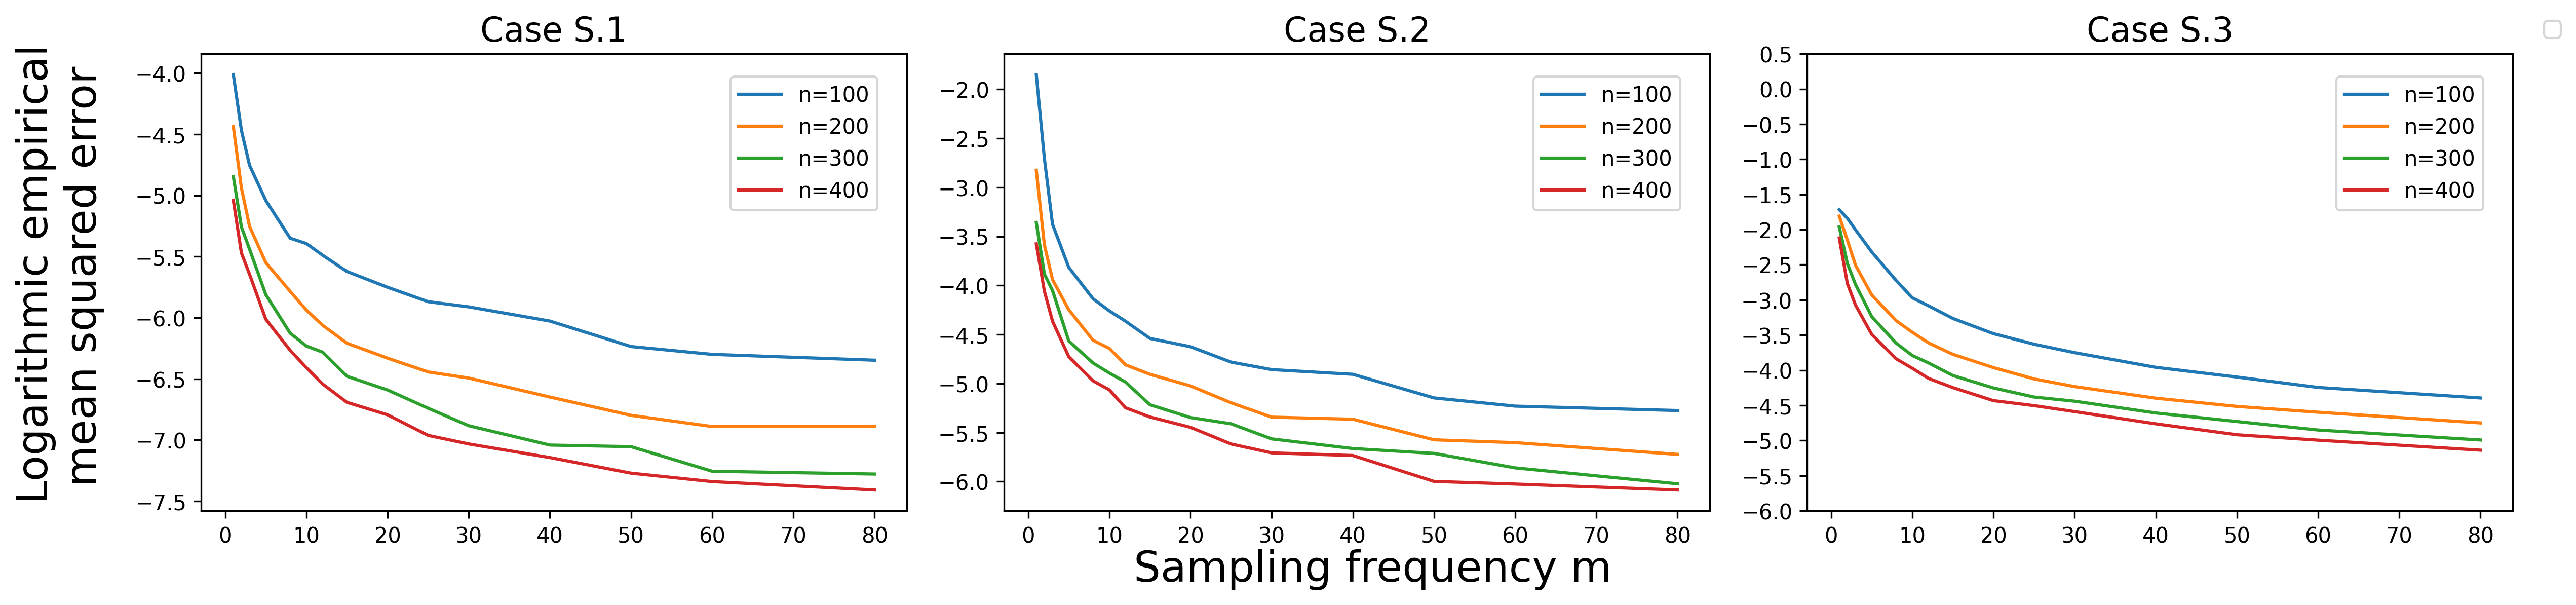

In [23]:
n_vector = [100,200,300,400] 
m_vector = [1,2,3,5,8,10,12,15,20,25,30,40,50,60,80] 

def subplotv(ax,n_vector,m_vector,path,title1,ylim = None,yticks=None):
    nnressum = np.zeros((len(n_vector), len(m_vector)))
    for i in range(len(n_vector)): 
        for j in range(len(m_vector)): 
            n_train = n_vector[i]
            m_train = m_vector[j]

            resnmdd = np.load(path+str(n_train)+"m"+str(m_train)+".npy",allow_pickle=True) 

            col_indexes = np.arange(0, resnmdd.shape[1], 3) 
            idx = np.argmin(resnmdd[:,col_indexes],axis=1)
            resnmdd[np.arange(resnmdd.shape[0]),np.argmin(resnmdd[:,col_indexes],axis=1)]
            kk1 = np.array([(resnmdd[i, 3*idx[i]], resnmdd[i, 3*idx[i]+1], resnmdd[i, 3*idx[i]+2]) for i in range(resnmdd.shape[0])])  
            kk1 = kk1.mean(axis=0) 
            nnressum[i][j] = kk1[1] 
    # 生成数据
    x = np.sort(m_vector)
    for i in range(len(n_vector)):
        ax.plot(x, np.log(nnressum[i,:]), label='n='+str(n_vector[i])) # nnressum[i,:]

    if ((ylim is None) is False):
        ax.set_ylim(ylim)
        if ((yticks is None) is False):
            ax.set_yticks(yticks,yticks)
    # ax.set_yticks(list(range(-7,-1,1)),list(range(-7,-1,1)))

#    ax.set_xlim((min(m_vector), max(m_vector)))    
    y_major_locator=MultipleLocator(0.5)#以每3显示
    ax.legend(loc=2, bbox_to_anchor=(0.75,0.95), borderaxespad = 0.)
    ax.yaxis.set_major_locator(y_major_locator)
    ax.set_title(title1,size = 16)

fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, dpi=300,figsize=(16,3.8))
fig.text(s='Logarithmic empirical',rotation=90,x = -0.04, y = 0.13,fontsize = 20,) 
fig.text(s='mean squared error',rotation=90,x = -0.02, y = 0.16,fontsize = 20,)
fig.text(s='Sampling frequency m',x = 0.42, y = -0.02, fontsize = 20) 
fig.legend(loc=2, bbox_to_anchor=(1,0.95), borderaxespad = 0.)
path = "./CaseS1/res/res" 
subplotv(ax1,n_vector,m_vector,path,title1='Case S.1')#, yticks=np.linspace(-7,-2,11)
path = "./CaseS2/res/res" 
subplotv(ax2,n_vector,m_vector,path,title1='Case S.2')
path = "./CaseS3/res/res" 
subplotv(ax3,n_vector,m_vector,path,title1='Case S.3',ylim = (-6,0.5))
plt.tight_layout()

## nm plot of CaseS1

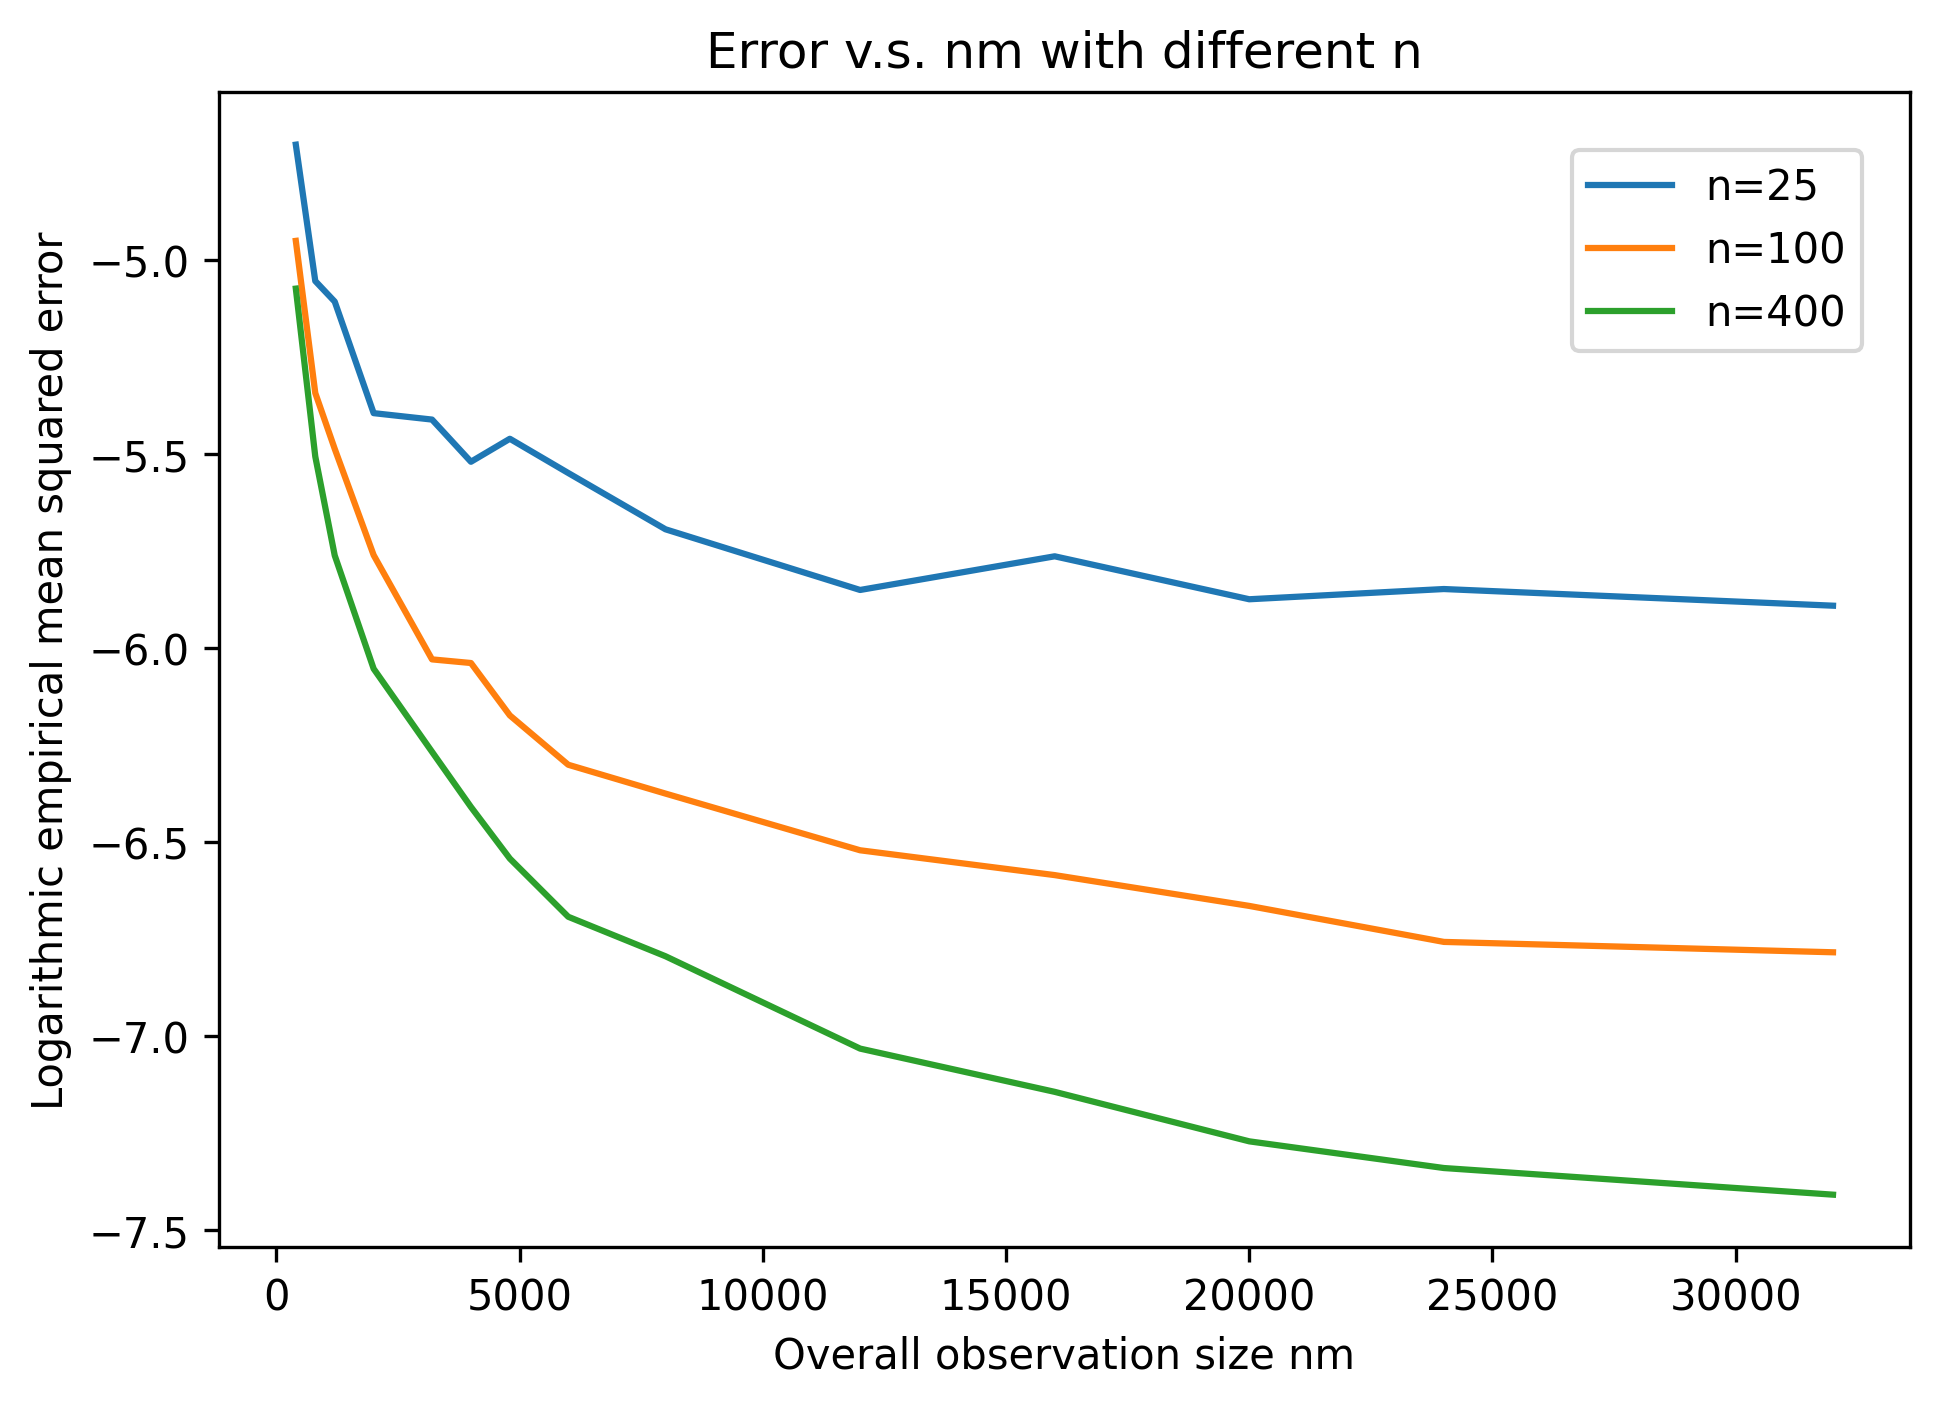

In [32]:
m_vector = np.array([1,2,3,5,8,10,12,15,20,30,40,50,60,80])
path = "./CaseS1/res/res"
m_vector1 = m_vector * 16
m_vector2 = m_vector * 4
m_vector3 = m_vector

nnressum = np.zeros((3, len(m_vector1)))

n_train = 25
for j in range(len(m_vector)): 
    m_train = m_vector1[j]
    resnmdd = np.load(path+str(n_train)+"m"+str(m_train)+".npy",allow_pickle=True) 
    col_indexes = np.arange(0, resnmdd.shape[1], 3) 
    idx = np.argmin(resnmdd[:,col_indexes],axis=1)
    resnmdd[np.arange(resnmdd.shape[0]),np.argmin(resnmdd[:,col_indexes],axis=1)]
    kk1 = np.array([(resnmdd[i, 3*idx[i]], resnmdd[i, 3*idx[i]+1], resnmdd[i, 3*idx[i]+2]) for i in range(resnmdd.shape[0])])  
    kk1 = kk1.mean(axis=0) 
    nnressum[0][j] = kk1[1] 

n_train = 100
for j in range(len(m_vector)): 
    m_train = m_vector2[j]
    resnmdd = np.load(path+str(n_train)+"m"+str(m_train)+".npy",allow_pickle=True) 
    col_indexes = np.arange(0, resnmdd.shape[1], 3) 
    idx = np.argmin(resnmdd[:,col_indexes],axis=1)
    resnmdd[np.arange(resnmdd.shape[0]),np.argmin(resnmdd[:,col_indexes],axis=1)]
    kk1 = np.array([(resnmdd[i, 3*idx[i]], resnmdd[i, 3*idx[i]+1], resnmdd[i, 3*idx[i]+2]) for i in range(resnmdd.shape[0])])  
    kk1 = kk1.mean(axis=0) 
    nnressum[1][j] = kk1[1]  


n_train = 400
for j in range(len(m_vector)): 
    m_train = m_vector3[j]
    resnmdd = np.load(path+str(n_train)+"m"+str(m_train)+".npy",allow_pickle=True) 
    col_indexes = np.arange(0, resnmdd.shape[1], 3) 
    idx = np.argmin(resnmdd[:,col_indexes],axis=1)
    resnmdd[np.arange(resnmdd.shape[0]),np.argmin(resnmdd[:,col_indexes],axis=1)]
    kk1 = np.array([(resnmdd[i, 3*idx[i]], resnmdd[i, 3*idx[i]+1], resnmdd[i, 3*idx[i]+2]) for i in range(resnmdd.shape[0])])  
    kk1 = kk1.mean(axis=0) 
    nnressum[2][j] = kk1[1]  


# 生成数据
x = np.sort(m_vector)*400
plt.figure(dpi=300,figsize=(16,5))
plt.subplot(121)

plt.plot(x, np.log(nnressum[0,:]), label='n=25')
plt.plot(x, np.log(nnressum[1,:]), label='n=100')
plt.plot(x, np.log(nnressum[2,:]), label='n=400')


y_major_locator=MultipleLocator(0.5)#以每3显示
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
plt.ylabel('Logarithmic empirical mean squared error')
plt.xlabel('Overall observation size nm')
# 添加图例和标题
plt.legend(loc=2, bbox_to_anchor=(0.8,0.95), borderaxespad = 0.)
plt.title("Error v.s. nm with different n")
# 显示图像
plt.show()